# Problem Statement

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. **We want to do some analysis of the average order value (AOV).** When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 


2. What metric would you report for this dataset?


3. What is its value?

# Summary of The Answers
By investigating the dataset, I found that some enormous order amount values caused the abnormal AOV. These values come from two different sources:

- A huge unit price of sneakers ($25725) in shop No. 78
- A very large number of items ordered (2000 items in each order) in shop No. 42

Even though these values are very different from most of the data, they did occur periodically over time. Therefore, after careful consideration, I decided not simply to drop the rows with large order_amount values. **Instead, I used the median order value (MOV) as the metric. The MOV value is $284.0, which is more reasonable to describe the dataset and more helpful for the analysis.**

In addition, I would recommend checking the data acquisition process for shop No.78, which has all its sneaker at an abnormal price of $25725. I would also check the orders placed in shop No. 42, as some orders were placed simultaneously down to second, and have the possibility of being counted repeatedly.

I provide my detailed analysis below to support my conclusions:

# Overview of the Dataset

First, let's get an overall picture of the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
# Read csv file
df_raw = pd.read_csv(r"C:\DataScience\Jupyter Files\Internship Applications\Shopify Winter 2021\2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv")

In [4]:
df_raw.head(20)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11
5,6,58,882,138,1,credit_card,2017-03-14 15:25:01
6,7,87,915,149,1,cash,2017-03-01 21:37:57
7,8,22,761,292,2,cash,2017-03-08 2:05:38
8,9,64,914,266,2,debit,2017-03-17 20:56:50
9,10,52,788,146,1,credit_card,2017-03-30 21:08:26


As described in a [shopify blog](https://www.shopify.ca/blog/average-order-value), "average order value (AOV) is the average amount of money each customer spends per transaction with your store. You can calculate your average order value using this simple formula: **Total revenue / number of orders = average order value**". 

After a quick view on the dataset, the features directly relevent for calculating AOV are:


- order_id: this feature describes the individual order ID. Ideally, every order should generate a distinct order ID. Total number of orders can thus be found by calculating the total number of order IDs.


- order_amount: this feature describes the value of each order. Total revenue can be found by sum up all the values in this column.


Based on the data, we can calculate the naive AOV stated in the problem.

In [5]:
aov_naive = sum(df_raw['order_amount']) / len(df_raw['order_id'])
print("Naive AOV: ${0:.2f}".format(aov_naive))

Naive AOV: $3145.13


Based on the definitions, the calculation process of the above AOV seems correct. However, **the problem is that an AOV of $3145.13 seems to be too big for sneaker shops**. So we need to find out the plausible causes. I start by looking at the overall statistics of the dataset:

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
order_id          5000 non-null int64
shop_id           5000 non-null int64
user_id           5000 non-null int64
order_amount      5000 non-null int64
total_items       5000 non-null int64
payment_method    5000 non-null object
created_at        5000 non-null object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB


In [7]:
df_raw.nunique()

order_id          5000
shop_id            100
user_id            301
order_amount       258
total_items          8
payment_method       3
created_at        4991
dtype: int64

In [8]:
df_raw.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


From the summary tables above, we can first notice neither Null value nor duplicate value exists in the dataset. **Besides, the data in both the *order_amount* and the *total_items* is severely skewed.** The 75% percentiles are significantly smaller than the maximum values in both columns. This is very likely the reason that caused an abnormal AOV, as averages are sensitive to outliers. 

Another interesting finding is that there are only 4991 unique values for *created_at* column. This column indicates the time to second when the purchase was made. This means that some orders were placed at precisely the same time. It is possible, but not very likely that different orders are placed right at the same time. So this part of data is worth delve into. 

In [9]:
df_raw.loc[df_raw.duplicated(subset=['created_at'], keep=False)].sort_values(by=['created_at'])

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
4567,4568,72,740,160,1,debit,2017-03-07 15:30:37
726,727,81,883,177,1,cash,2017-03-07 15:30:37
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00
611,612,86,838,130,1,debit,2017-03-09 10:46:09
1243,1244,94,920,134,1,cash,2017-03-09 10:46:09
1367,1368,42,926,1408,4,cash,2017-03-13 2:38:34
1756,1757,27,808,169,1,cash,2017-03-13 2:38:34


As shown in the table above, half of the orders that were placed simultaneously came from different shops and users. They are orders 4647 and 4568, orders 612 and 1244, orders 1368 and 1757, orders 3617 and 4898. These orders are expected as it is possible that different users coincidentally purchased different items at the same time. 

The rest of the orders came from the same shop (shop 42) and the same user (user 607). **These are unusual to me because these orders that happened at the same time could be combined into one single order**. I can think of two reasons:
1. The order amount or the total items for these orders exceeded the maximum value that could be entered into the system. So the system automatically split the orders into smaller portions. 
2. These were technical issues regarding these orders, and the orders were somehow repeatedly recorded. 
To identify which reason was true, extra information would be required. For example, I need to know if the system has maximum limits for the values of order amount/total items. If not, it is worth acquiring more information from the shop or the user to ensure that technical issues did not cause the duplicated records. 

# Exploratory Data Analysis
Based on the overview, we found that a possible reason that caused an abnormal AOV was the significantly right-skewed data in *order_amount* and *total_items* columns. However, before naively consider the unusually large values as outliers and remove them, I would like to understand the following questions:
1. Do the unusually large values occur only in one payment method?
2. Do the unusually large values occur only in a specific period?

If the unusually large values only occur at a specific time with a particular payment method, something was likely going wrong at that time. However, if the unusually large values occur periodically in different payment methods, they are probably just regular large orders. 

In [10]:
df_payment_method = df_raw.iloc[:, 3:6]
df_payment_method_sum = df_payment_method.groupby(['payment_method'], as_index=False).sum()
df_payment_method_size = df_payment_method.groupby(['payment_method']).size().reset_index(name='order_counts')
df_payment_method_stat = pd.merge(df_payment_method_sum, df_payment_method_size, on='payment_method')
df_payment_method_stat['average_item_value'] = df_payment_method_stat['order_amount'] / df_payment_method_stat['total_items']
df_payment_method_stat['average_order_value'] = df_payment_method_stat['order_amount'] / df_payment_method_stat['order_counts']

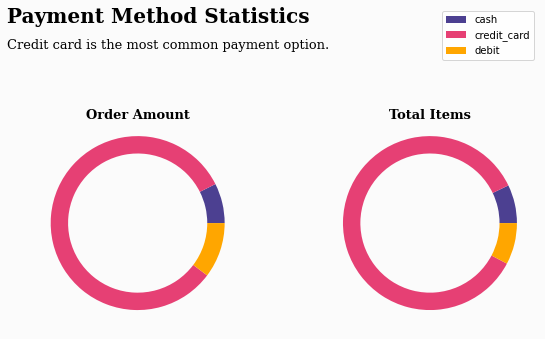

In [11]:
# Setting up figure and axes
fig = plt.figure(figsize=(10,4)) # create figure
gs = fig.add_gridspec(ncols=2, nrows=1)
gs.update(wspace=0.1, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1]) # create axes

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color

color_map = ["#4c4091", "#e64074", "#ffa600"]

# Order Amount
ax0.pie(x=df_payment_method_stat['order_amount'], colors=color_map, wedgeprops=dict(width=0.2))

ax0.text(-1.5, 2.3, 'Payment Method Statistics', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-1.5, 2, 'Credit card is the most common payment option.', 
         fontsize=13, fontweight='light', fontfamily='serif')

ax0.text(0, 1.2, 'Order Amount', fontsize=13, fontweight='bold', fontfamily='serif', horizontalalignment='center')



# Total Items
ax1.pie(x=df_payment_method_stat['total_items'], colors=color_map, wedgeprops=dict(width=0.2))
ax1.text(0, 1.2, 'Total Items', fontsize=13, fontweight='bold', fontfamily='serif', horizontalalignment='center')

ax1.legend(df_payment_method_stat["payment_method"], loc="upper right", bbox_to_anchor=(1, 1.5))
plt.show()

From the above figure, we can tell that credit card is the most used payment method. The distributions based on payment methods in the order amount and total items are aligned. 

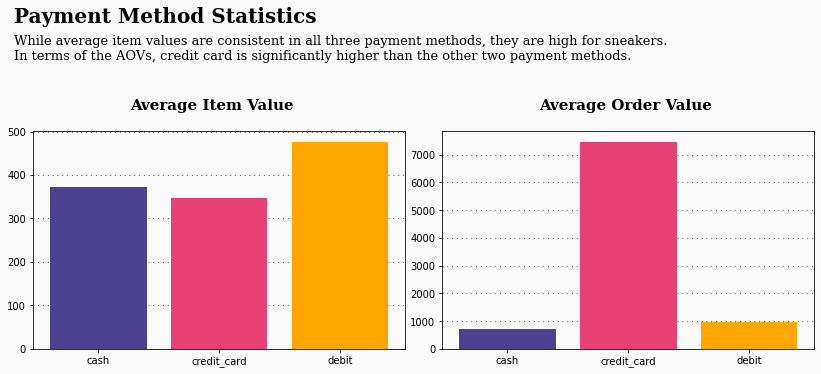

In [12]:
# Setting up figure and axes
fig = plt.figure(figsize=(14,4)) # create figure
gs = fig.add_gridspec(ncols=2, nrows=1)
gs.update(wspace=0.1, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1]) # create axes

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color

color_map = ["#4c4091", "#e64074", "#ffa600"]

# Average Item Value
ax0.grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax0.bar(df_payment_method_stat["payment_method"], 
        df_payment_method_stat['average_item_value'], 
        color=color_map, zorder=3
        )
ax0.text(-0.05, 1.5, 'Payment Method Statistics', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )
ax0.text(-0.05, 1.33, 'While average item values are consistent in all three payment methods, ' \
                     'they are high for sneakers. \n' \
                     'In terms of the AOVs, credit card is significantly higher than ' \
                     'the other two payment methods. ', 
         fontsize=13, fontweight='light', fontfamily='serif', transform=ax0.transAxes)
ax0.text(0.26, 1.1, 
         'Average Item Value', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )
# Average Order Value
ax1.grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax1.bar(df_payment_method_stat["payment_method"],
        df_payment_method_stat['average_order_value'], 
        color=color_map, zorder=3
       )

ax1.text(0.26, 1.1, 
         'Average Order Value', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax1.transAxes
        )

plt.show()

**The average item values for sneakers are higher than my expectation**. In my opinion, I would consider a pair of sneakers worth over \$300 as "expensive". This data may deviate from the general impressions for the price of a sneaker. 

We also notice that **the average order value for credit cards is significantly higher than the other two payment methods**. Considering that the average item value for credit cards is only about \$340, this means that the average number of items per order is much higher for credit cards. 

Let's take a closer look to see the distributions for the item value and items per order. 

In [13]:
df_raw['item_values'] = df_raw['order_amount'] / df_raw['total_items']
df_cash = df_raw[df_raw['payment_method']=='cash']
df_credit = df_raw[df_raw['payment_method']=='credit_card']
df_debit = df_raw[df_raw['payment_method']=='debit']

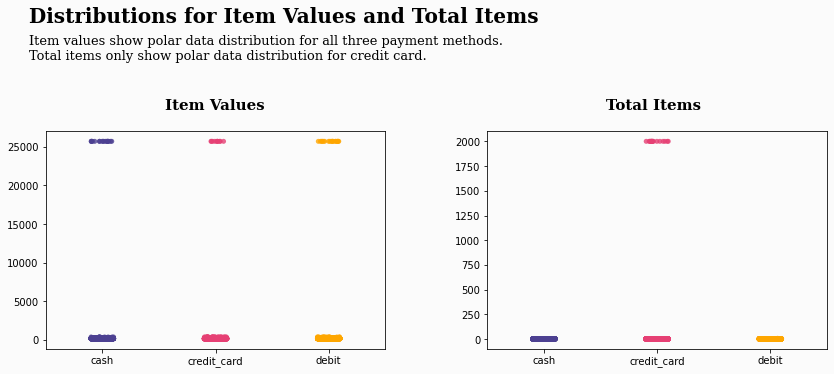

In [14]:
# Setting up figure and axes
fig = plt.figure(figsize=(14,4)) # create figure
gs = fig.add_gridspec(ncols=2, nrows=1)
gs.update(wspace=0.3, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1]) # create axes

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color

sns.set_palette(sns.color_palette(color_map))

sns.stripplot(ax=ax0, x='payment_method', y='item_values', data=df_raw, 
              marker='o', jitter=True, alpha=0.8)
ax0.set(xlabel=None)
ax0.set(ylabel=None)
ax0.text(-0.05, 1.5, 'Distributions for Item Values and Total Items', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )
ax0.text(-0.05, 1.33, 'Item values show polar data distribution for all three payment ' \
                     'methods. \n' \
                     'Total items only show polar data distribution for credit card. ', 
         fontsize=13, fontweight='light', fontfamily='serif', transform=ax0.transAxes
        )
ax0.text(0.35, 1.1, 
         'Item Values', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )

sns.stripplot(ax=ax1, x='payment_method', y='total_items', data=df_raw, marker='o', 
              jitter=True, alpha=0.8)
ax1.set(xlabel=None)
ax1.set(ylabel=None)
ax1.text(0.35, 1.1, 
         'Total Items', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax1.transAxes
        )
plt.show()

Interestingly, **all payment methods have very polar distributions for item values**, with most of the item values smaller than \\$1000 and some more than \\$25000. In terms of total items, as expected, **only credit card has a very polar distribution**, with some total items larger than 2000. 

Let's take a close look at these large values in item values and total items. 

In [15]:
df_raw[df_raw['item_values'] > 25000]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_values
160,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,25725.0
490,491,78,936,51450,2,debit,2017-03-26 17:08:19,25725.0
493,494,78,983,51450,2,cash,2017-03-16 21:39:35,25725.0
511,512,78,967,51450,2,cash,2017-03-09 7:23:14,25725.0
617,618,78,760,51450,2,cash,2017-03-18 11:18:42,25725.0
691,692,78,878,154350,6,debit,2017-03-27 22:51:43,25725.0
1056,1057,78,800,25725,1,debit,2017-03-15 10:16:45,25725.0
1193,1194,78,944,25725,1,debit,2017-03-16 16:38:26,25725.0
1204,1205,78,970,25725,1,credit_card,2017-03-17 22:32:21,25725.0
1259,1260,78,775,77175,3,credit_card,2017-03-27 9:27:20,25725.0


In [16]:
df_raw[df_raw['total_items'] > 1000]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_values
15,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,352.0
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
1104,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
1362,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
1562,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0


From the first table, we found that all sneakers with a price above \$25000 were sold by shop 78. **To my knowledge, it is implausible to sell sneakers at the cost of \$25725.0. Therefore, it is worth verifying if the item sold by shop 78 was truly sneakers.**

According to the second table, all orders with significant total item values happen between the same shop and the same user. Moreover, we've discussed the orders previously from the shop and the user when checking unusual orders that happened simultaneously. Intuitively, I think they might be outliers. 

We can verify that the high AOV was indeed caused by the orders with either a very high item price or a huge order quantity:

In [17]:
df_raw_new = df_raw[(df_raw['total_items']<1000) & (df_raw['item_values'] < 25000)]
df_payment_method_new = df_raw_new.iloc[:, 3:6]
df_payment_method_sum_new = df_payment_method_new.groupby(['payment_method'], as_index=False).sum()
df_payment_method_size_new = df_payment_method_new.groupby(['payment_method']).size().reset_index(name='order_counts')
df_payment_method_stat_new = pd.merge(df_payment_method_sum_new, df_payment_method_size_new, on='payment_method')
df_payment_method_stat_new['average_item_value'] = df_payment_method_stat_new['order_amount'] \
                                                    / df_payment_method_stat_new['total_items']
df_payment_method_stat_new['average_order_value'] = df_payment_method_stat_new['order_amount'] \
                                                    / df_payment_method_stat_new['order_counts']

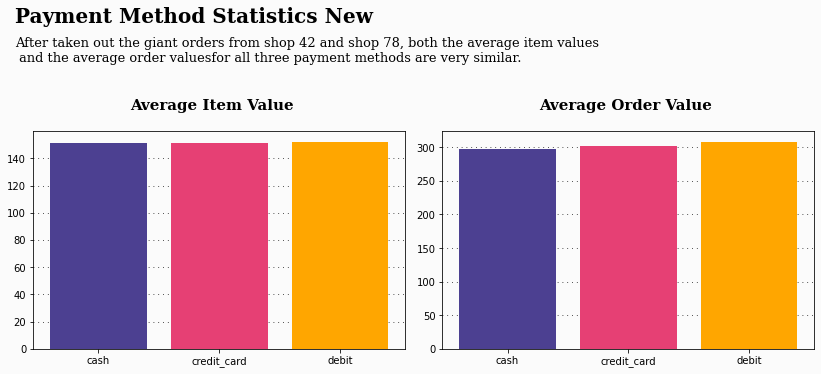

In [18]:
# Setting up figure and axes
fig = plt.figure(figsize=(14,4)) # create figure
gs = fig.add_gridspec(ncols=2, nrows=1)
gs.update(wspace=0.1, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1]) # create axes

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color

color_map = ["#4c4091", "#e64074", "#ffa600"]

# Average Item Value
ax0.grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax0.bar(df_payment_method_stat_new["payment_method"], 
        df_payment_method_stat_new['average_item_value'], 
        color=color_map, zorder=3
)
ax0.text(-0.05, 1.5, 
         'Payment Method Statistics New', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )
ax0.text(-0.05, 1.32, 
         'After taken out the giant orders from shop 42 and shop 78, ' \
         'both the average item values \n and the average order values' \
         'for all three payment methods are very similar.',
         fontsize=13, fontweight='light', fontfamily='serif', transform=ax0.transAxes
        )
ax0.text(0.26, 1.1, 
         'Average Item Value', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )
# Average Order Value
ax1.grid(color='black', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax1.bar(df_payment_method_stat_new["payment_method"], 
        df_payment_method_stat_new['average_order_value'], 
        color=color_map, zorder=3,
        )

ax1.text(0.26, 1.1, 
         'Average Order Value', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax1.transAxes
        )
plt.show()

After taken out the "outliers", both the average item value and the AOV became very consistent over three payment methods. Also, both values are closer to the public impression. 

However, if we take a closer look at the *created_at* column for those giant orders, we can notice that the orders were placed quite consistently over time. This means that these orders are probably not "errors". Let's check the AOV over time each day:

In [19]:
df_time = df_raw.iloc[:, 3:7]
df_time['created_at_date'] = pd.to_datetime(df_time['created_at'].str.split(' ').apply(lambda x: x[0]))
df_time_sum = df_time.groupby(['payment_method', 'created_at_date'], as_index=False).sum()
df_time_size = df_time.groupby(['payment_method', 'created_at_date']).size().reset_index(name='order_counts')
df_time_stat = pd.merge(df_time_sum, df_time_size, on=['payment_method', 'created_at_date'])
df_time_stat['average_order_value'] = df_time_stat['order_amount'] / df_time_stat['order_counts']
df_time_cash = df_time_stat.loc[df_time_stat['payment_method']=='cash'].sort_values(by=['created_at_date'])
df_time_debit = df_time_stat.loc[df_time_stat['payment_method']=='debit'].sort_values(by=['created_at_date'])
df_time_credit = df_time_stat.loc[df_time_stat['payment_method']=='credit_card'].sort_values(by=['created_at_date'])

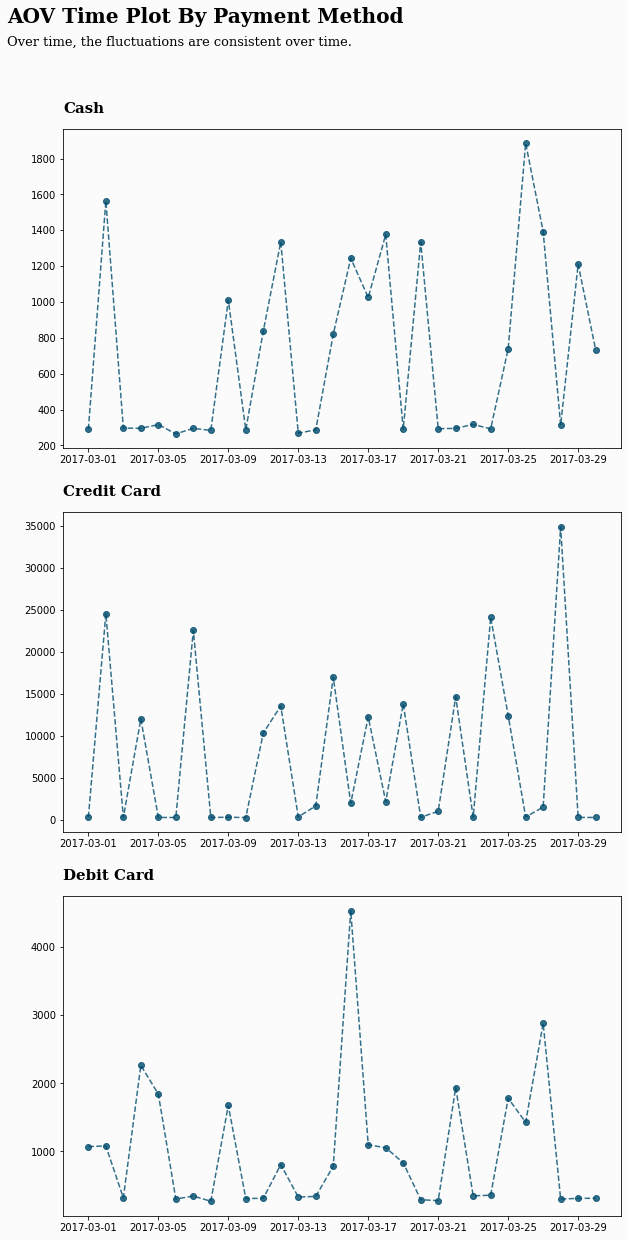

In [22]:
# Setting up figure and axes
fig = plt.figure(figsize=(10,20)) # create figure
gs = fig.add_gridspec(3, 1)
gs.update(wspace=0.1, hspace=0.2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0]) 
ax2 = fig.add_subplot(gs[2, 0]) 

# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) # axes background color
ax1.set_facecolor(background_color) # axes background color
ax2.set_facecolor(background_color) # axes background color

# Cash
ax0.plot(df_time_cash['created_at_date'], df_time_cash["average_order_value"], 'o--', color="#004c6d", alpha=0.8)
ax0.text(-0.1, 1.33, 'AOV Time Plot By Payment Method', fontsize=20, fontweight='bold', fontfamily='serif', transform=ax0.transAxes)
ax0.text(-0.1, 1.26, 'Over time, the fluctuations are consistent over time.', 
         fontsize=13, fontweight='light', fontfamily='serif', transform=ax0.transAxes)
ax0.text(0, 1.05, 
         'Cash', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax0.transAxes
        )

# Credit Card
ax1.plot(df_time_credit['created_at_date'], df_time_credit["average_order_value"], 'o--', color="#004c6d", alpha=0.8)

ax1.text(0, 1.05, 
         'Credit Card', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax1.transAxes
        )

# Debit Card
ax2.plot(df_time_debit['created_at_date'], df_time_debit["average_order_value"], 'o--', color="#004c6d", alpha=0.8)
ax2.text(0, 1.05, 
         'Debit Card', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
         transform=ax2.transAxes
        )

plt.show()

We see that over time, all three payment methods have relatively consistent fluctuations. Therefore, **it may be inappropriate to remove the massive orders**. Instead, I believe the AOV of \\$3145.13 obtained does reflect the true AOV of the orders. However, because of the massive orders that significantly skewed the AOV, this metric might not be beneficial to represent the general order values. 

# A Better Metric
In the problem statement, it did not mention what question we want to answer using the AOV. A reasonable guess is that the team wants to understand a general order value within the month. They may want to compare it with the general order values in different months to analyze customer behavior over time. They may also want to compare it with a specific sneaker shop to see whether this sneaker shop performs better or worse than average so that particular business strategies can be designed for the shop. After all, if the purpose is to understand the general order value of the sneakers, in this case, a **median order value (MOV)** would be more appropriate than the AOV. The MOV is much less sensitive to the outliers and will better represent the center of the data. 

The MOV can be found as follow:

In [21]:
mov = df_raw['order_amount'].median()
print("The median order value is: ${}".format(mov))

The median order value is: $284.0
